##Robustness through Perturbations
In 2014, Srivastava et al. [Srivastava et al., 2014] developed a clever idea for how to apply Bishop’s idea to the internal layers of a network, too. Namely, they proposed to inject noise into each layer of the network before calculating the subsequent layer during training. They realized that when training a deep network with many layers, injecting noise enforces smoothness just on the input-output mapping.

Their idea, called **dropout**, involves injecting noise while computing each internal layer during forward propagation, and it has become a standard technique for training neural networks. The method is called dropout because we literally drop out some neurons during training. Throughout training, on each iteration, standard dropout consists of zeroing out some fraction of the nodes in each layer before calculating the subsequent layer.

##Dropout in Practice
When we apply dropout to a hidden layer,
zeroing out each hidden unit with probability $p$,
the result can be viewed as a network
containing only a subset of the original neurons.
![MLP before and after dropout.](http://d2l.ai/_images/dropout2.svg)
:label:`fig_dropout2`
In the diagram above, $h_2$ and $h_5$ are removed.

Instalasi

In [1]:
!pip install d2l==0.17.2

     |████████████████████████████████| 82 kB 524 kB/s 
     |████████████████████████████████| 20.1 MB 1.2 MB/s 
     |████████████████████████████████| 11.6 MB 38.1 MB/s 
     |████████████████████████████████| 61 kB 6.6 MB/s 
     |████████████████████████████████| 9.9 MB 41.6 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the p

In [2]:
pip install matplotlib==3.0.2

     |████████████████████████████████| 12.9 MB 4.3 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.3.3
    Uninstalling matplotlib-3.3.3:
      Successfully uninstalled matplotlib-3.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
plotnine 0.6.0 requires matplotlib>=3.1.1, but you have matplotlib 3.0.2 which is incompatible.
mizani 0.6.0 requires matplotlib>=3.1.1, but you have matplotlib 3.0.2 which is incompatible.
d2l 0.17.2 requires matplotlib==3.3.3, but you have matplotlib 3.0.2 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


##Implementation from Scratch

In the following code, we implement a dropout_layer function. Dividing the survivors by 1.0-dropout.

In [3]:
import tensorflow as tf
from d2l import tensorflow as d2l


def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    # In this case, all elements are dropped out
    if dropout == 1:
        return tf.zeros_like(X)
    # In this case, all elements are kept
    if dropout == 0:
        return X
    mask = tf.random.uniform(
        shape=tf.shape(X), minval=0, maxval=1) < 1 - dropout
    return tf.cast(mask, dtype=tf.float32) * X / (1.0 - dropout)

We can test out the dropout_layer function on a few examples. In the following lines of code, we pass our input X through the dropout operation, with probabilities 0, 0.5, and 1, respectively.

In [4]:
X = tf.reshape(tf.range(16, dtype=tf.float32), (2, 8))
print(X)
print(dropout_layer(X, 0.))
print(dropout_layer(X, 0.5))
print(dropout_layer(X, 1.))

tf.Tensor(
[[ 0.  1.  2.  3.  4.  5.  6.  7.]
 [ 8.  9. 10. 11. 12. 13. 14. 15.]], shape=(2, 8), dtype=float32)
tf.Tensor(
[[ 0.  1.  2.  3.  4.  5.  6.  7.]
 [ 8.  9. 10. 11. 12. 13. 14. 15.]], shape=(2, 8), dtype=float32)
tf.Tensor(
[[ 0.  0.  4.  0.  0. 10. 12.  0.]
 [ 0.  0. 20.  0.  0.  0.  0.  0.]], shape=(2, 8), dtype=float32)
tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]], shape=(2, 8), dtype=float32)


###Defining Model Parameters
We work with the Fashion-MNIST dataset. We define an MLP with two hidden layers containing 256 units each.

In [5]:
num_outputs, num_hiddens1, num_hiddens2 = 10, 256, 256

###Defining the Model

The model below applies dropout to the output of each hidden layer (following the activation function). We can set dropout probabilities for each layer separately. A common trend is to set a lower dropout probability closer to the input layer. Below we set it to 0.2 and 0.5 for the first and second hidden layers, respectively. We ensure that dropout is only active during training.

In [6]:
dropout1, dropout2 = 0.2, 0.5

class Net(tf.keras.Model):
    def __init__(self, num_outputs, num_hiddens1, num_hiddens2):
        super().__init__()
        self.input_layer = tf.keras.layers.Flatten()
        self.hidden1 = tf.keras.layers.Dense(num_hiddens1, activation='relu')
        self.hidden2 = tf.keras.layers.Dense(num_hiddens2, activation='relu')
        self.output_layer = tf.keras.layers.Dense(num_outputs)

    def call(self, inputs, training=None):
        x = self.input_layer(inputs)
        x = self.hidden1(x)
        if training:
            x = dropout_layer(x, dropout1)
        x = self.hidden2(x)
        if training:
            x = dropout_layer(x, dropout2)
        x = self.output_layer(x)
        return x

net = Net(num_outputs, num_hiddens1, num_hiddens2)

###Training and Testing
This is similar to the training and testing of MLPs.

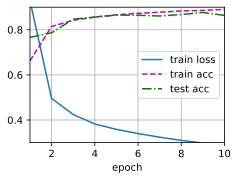

In [7]:
num_epochs, lr, batch_size = 10, 0.5, 256
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = tf.keras.optimizers.SGD(learning_rate=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

Output of cell [7]:

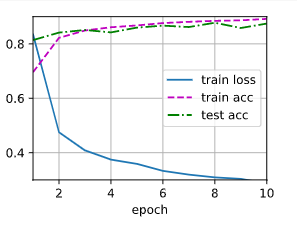

##Concise Implementation
With high-level APIs, all we need to do is add a Dropout layer after each fully-connected layer. During training, the Dropout layer will randomly drop out outputs of the previous layer (or equivalently, the inputs to the subsequent layer) according to the specified dropout probability. When not in training mode, the Dropout layer simply passes the data through during testing.

In [8]:
net = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation=tf.nn.relu),
    # Add a dropout layer after the first fully connected layer
    tf.keras.layers.Dropout(dropout1),
    tf.keras.layers.Dense(256, activation=tf.nn.relu),
    # Add a dropout layer after the second fully connected layer
    tf.keras.layers.Dropout(dropout2),
    tf.keras.layers.Dense(10),
])

Next, we train and test the model.

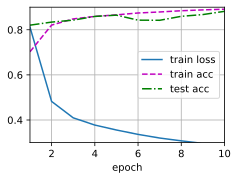

In [9]:
trainer = tf.keras.optimizers.SGD(learning_rate=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

Output of cell [9]:

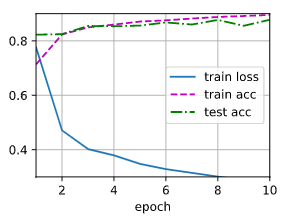

##Summary
* Beyond controlling the number of dimensions and the size of the weight vector, dropout is yet another tool to avoid overfitting. Often they are used jointly.
* Dropout is only used during training.